In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def lmm_drift(L, vol, dt, i, corr_matrix):
    """
    Calcule le drift pour le i-ème taux forward dans le LMM.
   
    Parameters:
    L : ndarray
        Taux forward actuels (1D).
    vol : ndarray
        Volatilités associées à chaque taux forward (1D). : 1 vol pour chaque maturité
    dt : float
        Pas de temps.
    i : int
        Index du taux forward.
    corr_matrix : ndarray
        Matrice de corrélation des taux forward (2D). (T1,…,T40 ; T1,…,T40)
       
    Returns:
    float
        Valeur du drift pour le i-ème taux forward.
    """
    drift = 0.0
    for j in range(i+1, len(L)):
        tau = dt  # intervalle de temps entre deux échéances
        numerator = vol[i] * vol[j] * corr_matrix[i, j] * tau * L[j]
        denominator = 1 + tau * L[j]
        drift += numerator / denominator
    return -drift
 

In [3]:
def lmm_noise(vol, dt, corr_matrix, n_sim):
    """
    Génère un bruit gaussien corrélé pour les taux forward.
 
    Parameters:
    vol : ndarray
        Volatilités (1D).
    dt : float
        Pas de temps.
    corr_matrix : ndarray
        Matrice de corrélation (2D).
    n_sim : int
        Nombre de simulations (chemins).
       
    Returns:
    ndarray
        Bruit gaussien corrélé (3D : [n_sim, n_taux, ])
    """
    n_factors = len(vol)
    chol = np.linalg.cholesky(corr_matrix)
    Z = np.random.normal(size=(n_sim, n_factors))
    return np.matmul(Z, chol.T) * np.sqrt(dt)

In [4]:
def lmm_sim(L0, vol, corr_matrix, dt, n_steps, n_sim):
    """
    Simule les taux LIBOR selon le Libor Market Model.
 
    Parameters:
    L0 : ndarray
        Taux initiaux (1D).
    vol : ndarray
        Volatilités (1D).
    corr_matrix : ndarray
        Matrice de corrélation (2D).
    dt : float
        Pas de temps.
    n_steps : int
        Nombre d'étapes de temps.
    n_sim : int
        Nombre de simulations.
       
    Returns:
    ndarray
        Taux LIBOR simulés (4D: [n_simulations, n_steps+1, n_taux])
    """
    n_taux = len(L0)
    L = np.zeros((n_sim, n_steps + 1, n_taux))
    L[:, 0, :] = L0
 
    for t in range(1, n_steps + 1):
        for i in range(n_taux):
            drift = np.array([lmm_drift(L[s, t - 1, :], vol, dt, i, corr_matrix) for s in range(n_sim)])
            dW = lmm_noise(vol, dt, corr_matrix, n_sim)[:, i]
            L[:, t, i] = L[:, t - 1, i] * np.exp((drift - 0.5 * vol[i]**2) * dt + vol[i] * dW)
   
    return L

In [5]:
#importation données
data3000=pd.read_csv("EUR_4Q24_EUR_3000.csv",sep=";", encoding="utf-8")
data3000 = data3000.replace(',', '.', regex=True).astype(float)
data3000.columns = data3000.columns.str.replace(' ', '_')

In [6]:
#On reshape les données en (3000x41x40)
spot_cols = [col for col in data3000.columns if 'EUR_Nom_Spot_' in col]
spot_cols = sorted(spot_cols, key=lambda x: int(x.split('_')[-1]))
spot_data = data3000[spot_cols].values  # shape (123000, 40)
Xtrain = spot_data.reshape((3000, 41, 40))  # 3000 scénarios, 41 time_steps, 40 maturités

Xtrain = tf.convert_to_tensor(Xtrain, dtype=tf.float32)

In [7]:
#Paramètres de base
n_maturities = 40
n_simulations = 3000
n_steps = 40
dt = 1.0  # Trimestriel
vol = np.full(n_maturities, 0.3)  # sigma constant

# Matrice de corrélation : 1 sur la diagonale, 0.5 ailleurs
corr_matrix = np.full((n_maturities, n_maturities), 0.5)
np.fill_diagonal(corr_matrix, 1.0)
# Taux initiaux L0 : une courbe croissante légère
L0 = Xtrain[0, 0, :].numpy()  # Tensor -> Numpy array

# Simulation
scenarios = lmm_sim(L0, vol, corr_matrix, dt, n_steps, n_simulations)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


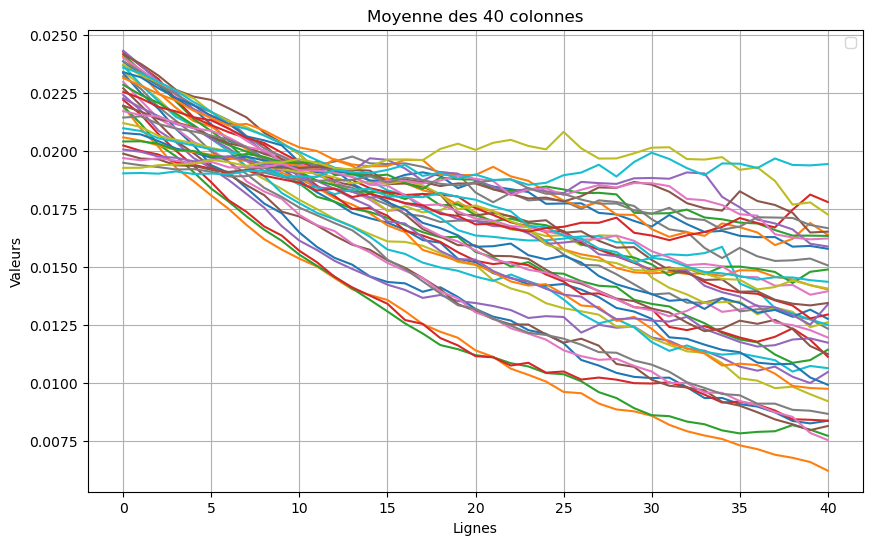

In [8]:
mean_paths = np.mean(scenarios, axis=0)

# Supposons que mean_paths soit de forme (41, 40)
# mean_paths contient les 40 colonnes et 41 valeurs par colonne

plt.figure(figsize=(10, 6))

X=np.arange(41)

# Tracer chaque colonne comme une courbe
for i in range(40):
    Y=[]
    for j in range(41):
        Y.append(mean_paths[j][i])
    plt.plot(X,Y)

plt.title('Moyenne des 40 colonnes')
plt.xlabel('Lignes')
plt.ylabel('Valeurs')
plt.legend()
plt.grid(True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


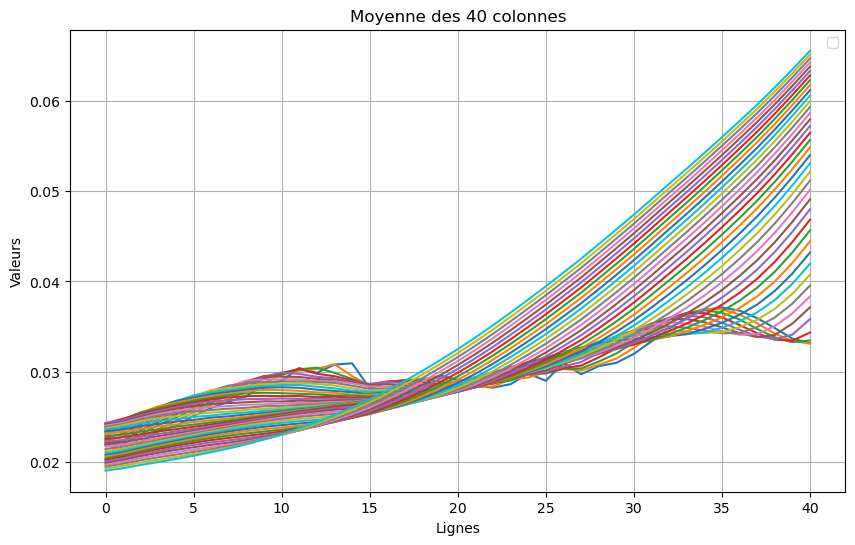

In [9]:
#ALLURE ATTENDU
mean_paths = np.mean(Xtrain, axis=0)

# Supposons que mean_paths soit de forme (41, 40)
# mean_paths contient les 40 colonnes et 41 valeurs par colonne

plt.figure(figsize=(10, 6))

X=np.arange(41)

# Tracer chaque colonne comme une courbe
for i in range(40):
    Y=[]
    for j in range(41):
        Y.append(mean_paths[j][i])
    plt.plot(X,Y)

plt.title('Moyenne des 40 colonnes')
plt.xlabel('Lignes')
plt.ylabel('Valeurs')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
###PARTIE DU PINN###

In [41]:
n_maturities = 40
n_steps = 40
dt = 0.25
n_simulations = 3000
Xtrain = Xtrain[:10]  # shape devient (1500, 41, 40)
L0 = Xtrain[0, 0, :].numpy()  # shape (40,)

In [33]:
class PINN(tf.keras.Model):
    def __init__(self, n_maturities):
        super(PINN, self).__init__()
        self.log_sigma = tf.Variable(tf.zeros([n_maturities]), trainable=True)

        # L est triangle inférieur brut pour corrélation
        self.L_raw = tf.Variable(
            tf.random.normal([n_maturities, n_maturities]), trainable=True
        )

    def call(self, inputs=None):
        sigma = tf.math.exp(self.log_sigma)

        # Force L à être triangulaire inférieure
        L = tf.linalg.band_part(self.L_raw, -1, 0)

        # rho = L @ L.T
        cov = tf.matmul(L, tf.transpose(L))

        # Normalisation en matrice de corrélation
        d = tf.sqrt(tf.linalg.diag_part(cov))
        outer_d = tf.tensordot(d, d, axes=0)
        corr = cov / outer_d

        # On remet bien 1.0 sur la diagonale (sécurité)
        corr = tf.linalg.set_diag(corr, tf.ones(n_maturities))

        return sigma, corr

In [36]:
def compute_loss(model, Xtrue):
    sigma, rho = model(None)

    # on reste dans numpy_function pour l'instant, donc pas besoin de .numpy()
    def simulate(sigma_np, rho_np):
        epsilon = 1e-6  # Petite valeur pour régulariser
        rho_np = 0.5 * (rho_np + rho_np.T)  # symétrisation de sécurité
        rho_np += epsilon * np.eye(n_maturities)  # régularisation diagonale
        return lmm_sim(L0, sigma_np, rho_np, dt, n_steps, n_simulations)


    Xpred = tf.numpy_function(
        func=simulate,
        inp=[sigma, rho],
        Tout=tf.float64
    )
    Xpred = tf.convert_to_tensor(Xpred, dtype=tf.float32)
    return tf.reduce_mean((Xpred - Xtrue) ** 2)


In [42]:
# Entraînement
model = PINN(n_maturities)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2)

for epoch in range(100):  # Ajuste le nombre d'époques si nécessaire
    with tf.GradientTape() as tape:
        loss = compute_loss(model, Xtrain)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    print(f"Epoch {epoch} - Loss: {loss.numpy():.6f}")

KeyboardInterrupt: 